# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [7]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [14]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  1.397820  0.787116  0.0  0.059256 -0.292197  0.942094  0  0   1.621961   
1  0.469724  2.375820  0.0  0.840004 -1.396224 -1.167714  2  2  16.322160   
2 -0.362779  1.404465  1.0  0.196479 -0.213016 -0.402534  2  3  33.382032   
3 -0.761984 -0.336759  1.0  0.365809  0.027429 -0.275518  2  3  37.264147   
4 -0.144017  2.151200  0.0  0.915854  2.228301  0.966747  1  0  31.424873   

            y  
0   29.436270  
1  264.178189  
2  397.415085  
3  259.221571  
4  456.339715  
True causal estimate is 14.622058098675435


In [15]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

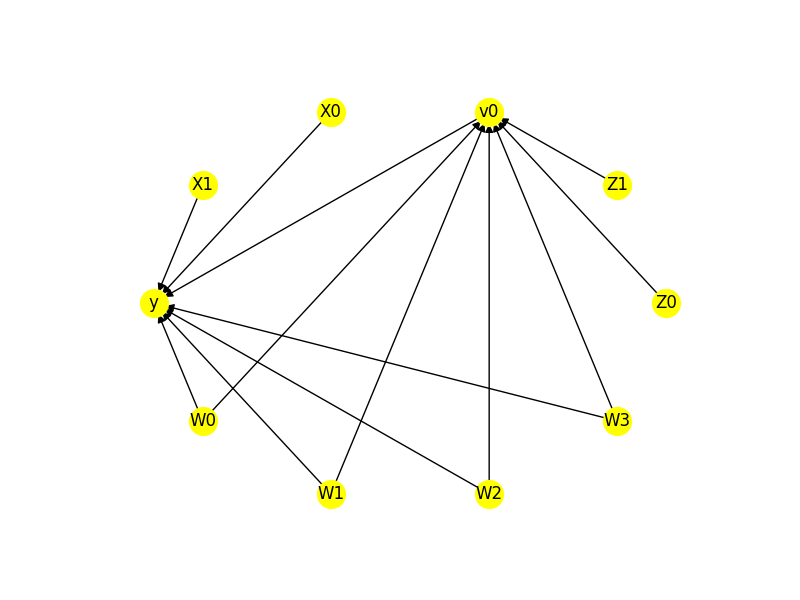

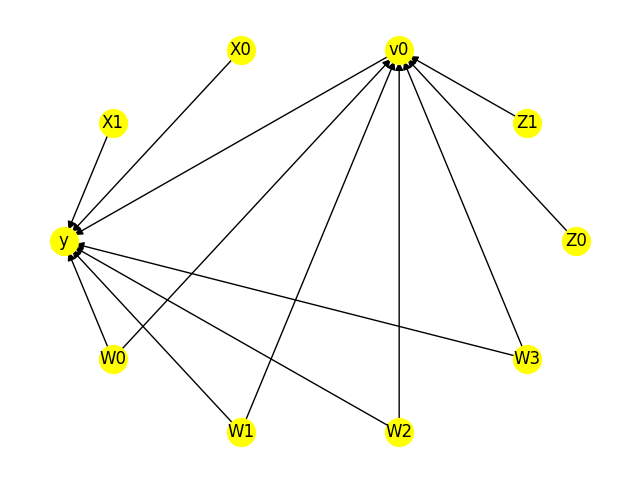

In [16]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [17]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [18]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

## Realized estimand
b: y~v0+W0+W3+W2+W1+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 14.621896073360222
### Conditional Estimates
__categorical__X1  __categorical__X0
(-3.162, -0.106]   (-2.751, 0.0971]      7.323499
                   (0.0971, 0.679]       9.909550
                   (0.679, 1.2]         11.695486
                   (1.2, 1.784]         13.356207
                   (1.784, 4.66]        16.195075
(-0.106, 0.477]    (-2.751, 0.0971]      8.836545
                   (0.0971, 0.679]      11.712891
                   (0.679, 1.2]         13.474216
                   (1.2, 1.784]         15.277560
                   (1.784, 4.66]  

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

## Realized estimand
b: y~v0+W0+W3+W2+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 17.465340096118034
Effect estimates: [16.24844323 16.08048254 17.83959283 ... 24.32469142 16.88379638
 19.31589888]



In [20]:
print("True causal estimate is", data["ate"])

True causal estimate is 14.622058098675435


In [21]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

## Realized estimand
b: y~v0+W0+W3+W2+W1 | X1,X0
Target units: 

## Estimate
Mean value: 14.453325732726968
Effect estimates: [16.14221204 16.58333274 11.48882679 ...  9.99370065  9.89942695
 12.63585706]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

## Realized estimand
b: y~v0+W0+W3+W2+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 14.466805538368696
Effect estimates: [16.14571527 16.47019917 11.46598005 ... 10.06343528  9.89409031
 12.66660775]
95.0% confidence interval: (array([16.2036944 , 16.37060741, 11.28709365, ...,  9.93515903,
        9.6144389 , 12.65223331]), array([16.53461864, 16.91539009, 11.70067399, ..., 10.21992329,
       10.08818995, 12.85633812]))



### Can provide a new inputs as target units and estimate CATE on them.

In [23]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[12.75731603 11.35625296 14.2763     14.85331682 13.8512601  12.80646188
 11.22757349 10.6592364  13.69206926 14.92172785]


### Can also retrieve the raw EconML estimator object for any further operations

In [24]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [25]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.561145  0.617870  1.0  0.778209 -0.945561  0.840927 -0.937063   
1     0.505237  3.214991  1.0  0.013149 -2.349541  1.021428 -0.899769   
2     0.477394  1.992340  0.0  0.424910 -1.211511  1.921989  0.115755   
3     1.061970  1.163668  1.0  0.087868 -2.612194  0.449882 -0.436637   
4     1.880444  1.236172  0.0  0.729415 -2.370369  0.318589 -0.767491   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.573303  0.560169  1.0  0.318092  0.355041 -0.346658  1.660340   
9996 -1.305997  0.266337  1.0  0.835334 -1.107134  1.603941  1.293988   
9997  2.182257  0.884999  1.0  0.109273  1.075882  1.889109 -1.618880   
9998  2.946578  0.774814  0.0  0.167299  0.052511  1.167421 -1.526434   
9999 -0.249918  1.591061  1.0  0.496782  0.280712  1.394972 -0.653561   

            W3  v0  y  
0    -2.187687   1  0  
1    -0.479631   1  1  
2     0.522142   1  1  
3    -2.401421   1  1  
4  

#### Using DRLearner estimator

In [26]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

## Realized estimand
b: y~v0+W0+W3+W2+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 0.5267749495958289
Effect estimates: [0.44366538 0.67097265 0.61484301 ... 0.74964767 0.82687136 0.51935986]

True causal estimate is 0.4977


### Instrumental Variable Method

In [27]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-10-27 13:18:27.492564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 13:18:27.492588: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-27 13:18:29.717845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-27 13:18:29.717973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 13:18:29.718017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcub

Epoch 1/25
313/313 [==============================] - 1s 1ms/step - loss: 8.1595
Epoch 2/25
313/313 [==============================] - 0s 987us/step - loss: 3.5632
Epoch 3/25
313/313 [==============================] - 0s 956us/step - loss: 3.1856
Epoch 4/25
313/313 [==============================] - 0s 949us/step - loss: 3.1077
Epoch 5/25
313/313 [==============================] - 0s 966us/step - loss: 3.0462
Epoch 6/25
313/313 [==============================] - 0s 962us/step - loss: 3.0178
Epoch 7/25
313/313 [==============================] - 0s 947us/step - loss: 2.9713
Epoch 8/25
313/313 [==============================] - 0s 943us/step - loss: 2.9322
Epoch 9/25
313/313 [==============================] - 0s 948us/step - loss: 2.9075
Epoch 10/25
313/313 [==============================] - 0s 948us/step - loss: 2.8913
Epoch 11/25
313/313 [==============================] - 0s 951us/step - loss: 2.8773
Epoch 12/25
313/313 [==============================] - 0s 960us/step - loss: 2.8723
Epo

### Metalearners

In [28]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     1.399950 -0.515336 -0.056221  0.919773 -1.230324  1.0  0.565194   
1     0.982183 -2.424278 -0.862488  0.360139  0.073206  1.0  0.663406   
2     1.013905 -2.119309 -0.282288 -1.076160 -0.499214  1.0  0.850087   
3     0.429137 -1.604920 -1.660896  2.495935 -0.794889  0.0  0.055122   
4     2.019043 -0.862393  0.442058 -0.437832 -1.769679  1.0  0.674089   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.226615 -0.297840 -0.095569  1.720292  1.081342  0.0  0.676001   
9996  0.397810  0.639170 -0.029127  0.266402 -1.801386  1.0  0.379901   
9997  0.227447 -0.918177 -0.613153 -0.446491  0.212924  1.0  0.137519   
9998  1.752834 -0.219743  0.107067 -2.689623 -0.864137  1.0  0.813741   
9999  0.089296 -1.242354  0.065015 -0.479438  0.600346  1.0  0.643558   

            W0        W1        W2        W3        W4  v0          y  
0     1.712928 -2.217302  0.026976 -1.378923 -0.558

In [29]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W4,W2,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W4,W2,W1,U) = P(y|v0,W0,W3,W4,W2,W1)

## Realized estimand
b: y~v0+X1+X3+X4+X2+X0+W0+W3+W4+W2+W1
Target units: ate

## Estimate
Mean value: 23.473433303936677
Effect estimates: [23.1467337  15.34721844 14.6328791  ... 26.6889289  20.47642352
  7.68695453]

True causal estimate is 12.515326015883243


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [30]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

KeyError: 'init_params'

## Refuting the estimate

### Adding a random common cause variable

In [ ]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

### Adding an unobserved common cause variable

In [ ]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

### Replacing treatment with a random (placebo) variable

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

### Removing a random subset of the data

In [ ]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

More refutation methods to come, especially specific to the CATE estimators.